# Source detection full reduction comparison

In [1]:
import sys
sys.path.append('.')
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook
from scipy.ndimage.filters import convolve

from library.gen_image import gen_image

from photutils.detection import DAOStarFinder
from photutils.datasets import load_star_image

from astropop.photometry.detection import daofind, starfind, sepfind

from astropy.stats import gaussian_fwhm_to_sigma

### General performance

- Photutils seems to find a bit more weak sources, but gives more doubled results in saturated stars.

- The missing stars in `starfind`, in general, are excluded due to bad `roundness`. Values of roundness computed from photutils seems to be smaller than computed by astropop. So, less exclusion.

- Weak stars near strong ones seems to suffer an interference in `roundness`.

- Segmentation is the only one to handle well saturated stars.

In [2]:
hdu = load_star_image()
im = hdu.data[:400, :400].astype('f8')
fwhm = 5
bkg = np.median(im)
rms = np.std(im)
thresh = 4

<IPython.core.display.Javascript object>


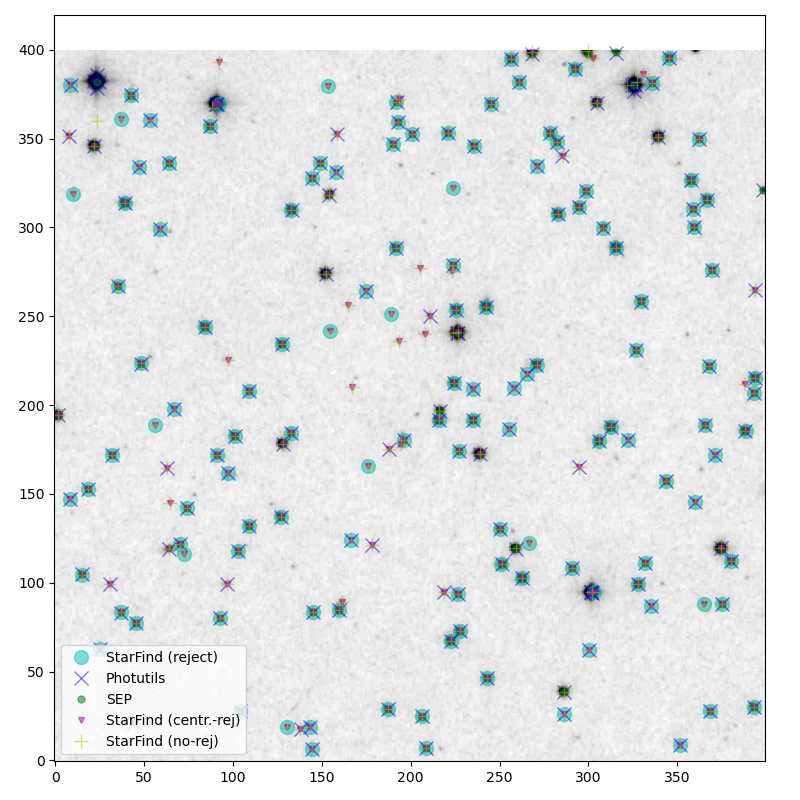

Photutils: 161
Starfind: 130
Starfind (no-rejection): 179
Starfind (centroid-rejection): 173


In [3]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

dao = DAOStarFinder(fwhm=fwhm, threshold=thresh*rms)
sources_photutils = dao.find_stars(im-bkg)
sources_sep = sepfind(im, thresh, bkg, rms)
sources_starfind_norej = starfind(im, thresh, bkg, rms, sharp_limit=None, round_limit=None, skip_invalid_centroid=True)
sources_starfind_crej = starfind(im, thresh, bkg, rms, sharp_limit=None, round_limit=None)
sources_starfind = starfind(im, thresh, bkg, rms)

ax.imshow(im, origin='lower', vmax=12000, cmap='gray_r')
ax.plot(sources_starfind['x'], sources_starfind['y'], 'co', ms=10, alpha=0.5, label='StarFind (reject)')
ax.plot(sources_photutils['xcentroid'], sources_photutils['ycentroid'], 'xb', ms=10, alpha=0.5, label='Photutils')
ax.plot(sources_sep['x'], sources_sep['y'], '.g', ms=10, alpha=0.5, label='SEP')
ax.plot(sources_starfind_crej['x'], sources_starfind_crej['y'], 'vm', ms=5, alpha=0.5, label='StarFind (centr.-rej)')
ax.plot(sources_starfind_norej['x'], sources_starfind_norej['y'], '+y', ms=10, alpha=0.5, label='StarFind (no-rej)')

print(f'Photutils: {len(sources_photutils)}')
print(f'Starfind: {len(sources_starfind)}')
print(f'Starfind (no-rejection): {len(sources_starfind_norej)}')
print(f'Starfind (centroid-rejection): {len(sources_starfind_crej)}')

plt.tight_layout()
plt.legend()
plt.show()

## Benchmark

Benchmarks and comparisons using standard photutils image, with `:400,:400` slice.

Filtering impact:
- No double source filtering (Table): 104±4 ms
- No double source filtering (ndarray): 109±4 ms
- Double source filtering (Table): 254±11 ms
- Double source filtering (ndarray): 111±2 ms

Centroid computation:
- Default DAOFind centroid: 254±11 ms
  - Problems with saturated sources.
- Astropy gaussian fit:
- Scipy gaussian fit:
- Center of mass: